In [1]:
import qutip
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from pulser import Pulse, Sequence, Register
from pulser_simulation import Simulation, SimConfig
from pulser_simulation.simresults import (
    CoherentResults,
    NoisyResults,
    SimulationResults,
)
from pulser.waveforms import RampWaveform
from pulser.devices import Chadoq2
from pulser.devices._device_datacls import Device
from typing import Union, cast

# Dephasing channel

The aim of this tutorial is to find a simple implementation of the dephasing channel for a single qubit, understanding it's effect then moving to a multi qubit implementation and compare it to the single qubit case.

## Useful methods


In [2]:
def get_population(rho, psi_0):
    """
        Expectation value of the input density matrix over a given direction psi_0
    """
    return psi_0.dag() * rho * psi_0


def clean_dynamics(clean_simu:Simulation):
    """
        Simulation without noise
    """
    return clean_simu.run()


def noise_channel(density_matrix, collapse_op):
    """
        Apply the underlying superoperator of a noise channel to an input density matrix
    """
    # We represent the superoperator using the Kraus representation
    output = 0 * density_matrix
    for c_op in collapse_op:
        output += c_op * density_matrix * c_op.dag()
    return output


def get_population_evolution(result: SimulationResults, state):
    """
        Evolution of the expectation value of the density matrix along a state over time
    """
    rho = result.states[0]
    population = []
    for rho_t in result.states:
        population.append(get_population(rho_t, state)[0][0])
    return population


def noisy_dynamics(clean_simu:Simulation, config:SimConfig, gamma:list):
    """
        Noisy simulation
    """
    simu = deepcopy(clean_simu)
    # Adding noise
    simu.add_config(config)
    result = simu.run()
    return simu, result


def mixed_state_stats(simu:Simulation, rho_0):
    """
        Expectation value of the mixed state due to a given noise channel
        along the ground state
    """
    psi_0 = simu.initial_state
    rho_mixed = noise_channel(rho_0, simu._collapse_ops)
    mixed_state = get_population(rho_mixed, psi_0)[0][0]
    return mixed_state


def trace_distance_evolution(rho, result:SimulationResults):
    """
        Evolution of the distance between a target density matrix
        and the system density matrix over time
    """
    tr_distances = [qutip.tracedist(rho_i, rho) for rho_i in result.states]
    return tr_distances


def plot_population(times, gammas, noisy_pops, mixed_states):
    """
        Plot the evolution of the initial population in different
        dephasing noise configurations.
    """
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rc('figure', dpi=200)
    plt.xlabel(r"Time ($\mu s$)")
    plt.ylabel(r"Population of $|1\rangle$")
    colors = ["red", "orange", "yellow", "green", "blue", "indigo", "violet", "pink", "black", "olive"]
    for gamma, noisy_pop, color, mixed_state in zip(gammas, noisy_pops, colors, mixed_states):
        plt.plot(times, noisy_pop, color=color, label=f"Dephasing probability = {gamma/2}")
        plt.axhline( mixed_state, color= color, linestyle="--", label="Mixed state")

    # put labels outside of the plot:
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()


def plot_distance(times, gammas, tr_distances):
    """
        Plot the distance between the expected density matrix and the
        target density matrix
    """
    for gamma, tr_dist in zip(gammas, tr_distances):
        plt.plot(times, tr_dist, label=f"Dephasing probability = {gamma/2}")
    plt.xlabel(r"Time ($\mu s$)")
    plt.ylabel(r"$|| \rho_{\rm mixed} - \rho || $")
    plt.ylim(0, 1.1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()

## Single atom noise simulation

We prepare a single atom

In [3]:
reg = Register.from_coordinates([(0, 0)], prefix="q")

We will implement the dephasing noise channel on a simple sequence instance at first.

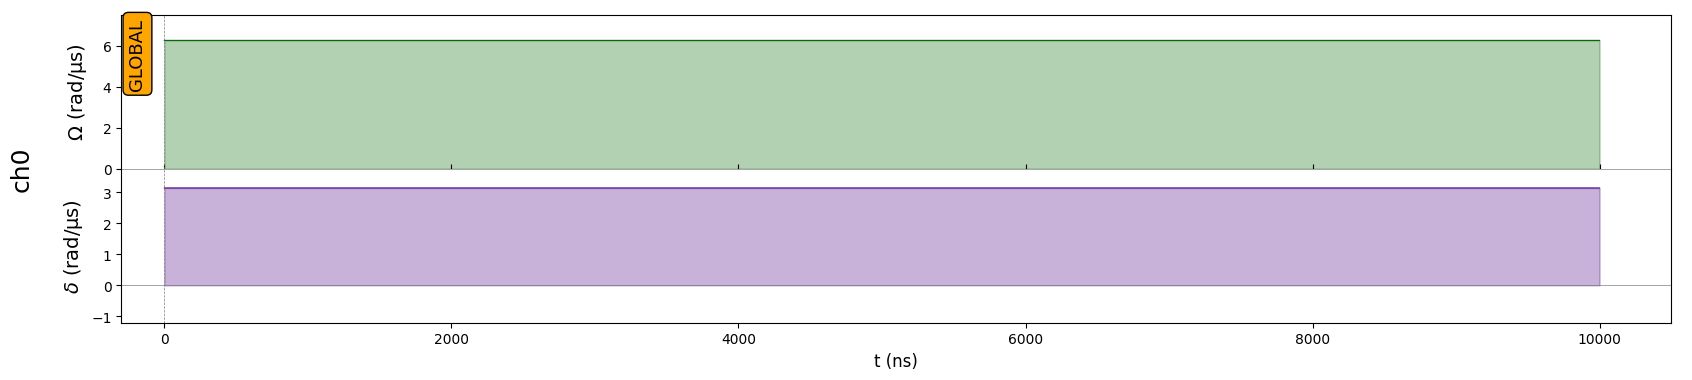

In [4]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")
duration = 10000
pulse = Pulse.ConstantPulse(duration, 2 * np.pi, np.pi, 0.0)
seq.add(pulse, "ch0")
seq.draw()

We now run the noiseless simulation

In [7]:
clean_simu = Simulation(seq, sampling_rate=0.05)
clean_res= clean_dynamics(clean_simu)

We can observe the exited population using the projector onto the Rydberg state

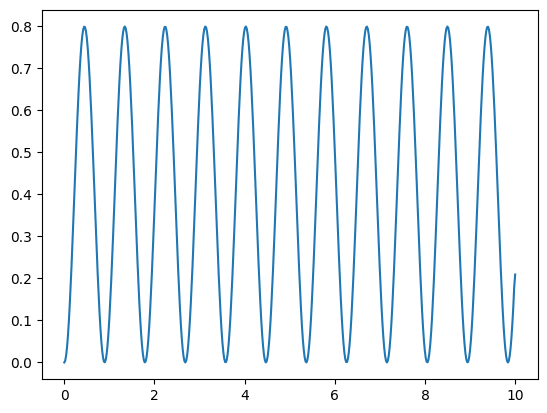

In [8]:
obs = qutip.basis(2, 0).proj()
plt.plot(clean_res._sim_times, clean_res.expect([obs])[0])
plt.show()

We are now going to look how the dephasing noise alter the output results. To do so we take several dephasing probabilities to understand the effects of the dephasing noise.

In [9]:
# Different simulation configurations
gammas = np.linspace(0, 2, 9)

Then we fetch different informations from tjhe system

In [10]:
results = []
noisy_pops = []
tr_distances = []
mixed_states = []
clean_pop = clean_dynamics(clean_simu)
for gamma in gammas:
    print("Dephasing probability = ", gamma/2)
    # Configure the dephasing noise
    config= SimConfig(
        noise="eff_noise",
        eff_noise_opers= [qutip.qeye(2), qutip.sigmaz()],
        eff_noise_probs= [1 - gamma/2, gamma/2]
    )
    simu, result  = noisy_dynamics(clean_simu, config, gamma)

    # Compute the mixed_state expectation value
    rho = result.states[0]
    psi_0 = simu.initial_state
    mixed_state = mixed_state_stats(simu, rho)

    # Ground state population evolution and distance from the mixed state
    noisy_pop = get_population_evolution(result, state=psi_0)
    tr_distance = trace_distance_evolution(rho, result)

    # Storage
    results.append(result)
    noisy_pops.append(noisy_pop)
    tr_distances.append(tr_distance)
    mixed_states.append(mixed_state)

Dephasing probability =  0.0
Dephasing probability =  0.125
Dephasing probability =  0.25
Dephasing probability =  0.375
Dephasing probability =  0.5
Dephasing probability =  0.625
Dephasing probability =  0.75
Dephasing probability =  0.875
Dephasing probability =  1.0


#### Population evolution

We recall that the mixed_state is defined as: $S_d(\rho_0) = p\rho_0 + (1-p)\sigma_z\rho_0\sigma_z$, $\rho_0 = \braket{g|g} = \braket{1|1}$, so $S_d(\rho_0) = \rho_0, \forall p$. This why the expectation value of the mixed state doesn't vary.

/home/varda/.virtualenvs/pulser/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


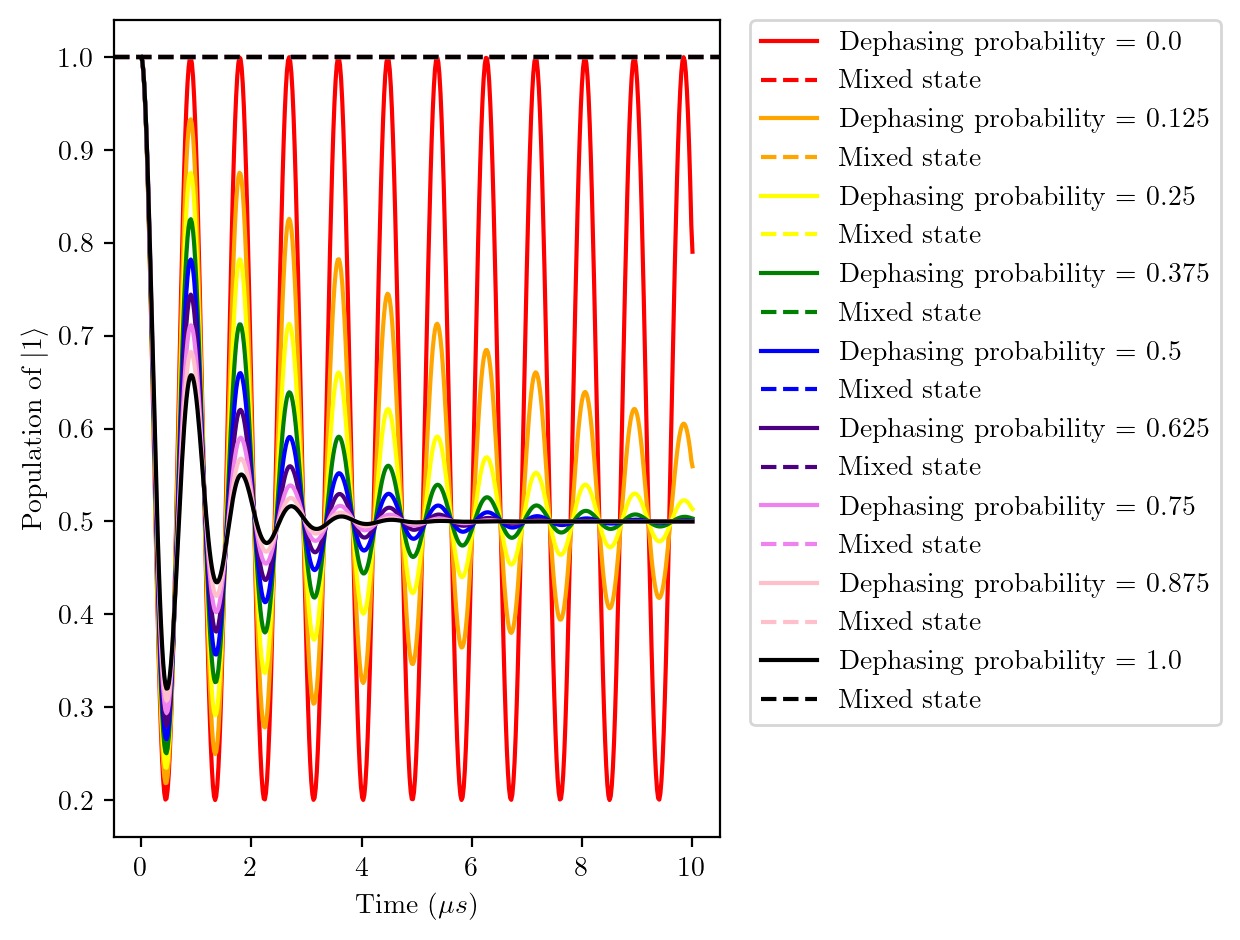

In [11]:
times = results[0]._sim_times
plot_population(times, gammas, noisy_pops, mixed_states)

When we look at how the population at the ground state evolves, we notice that they also goes to the high dephasing area, and the speed of converge increases with the dephasing probability $p$. The more $p$ is high, the higher the attenuation, the dephasing effects will be noticed.

Let's now take a look to the distance from the mixed state to have more insight

#### Trace distance

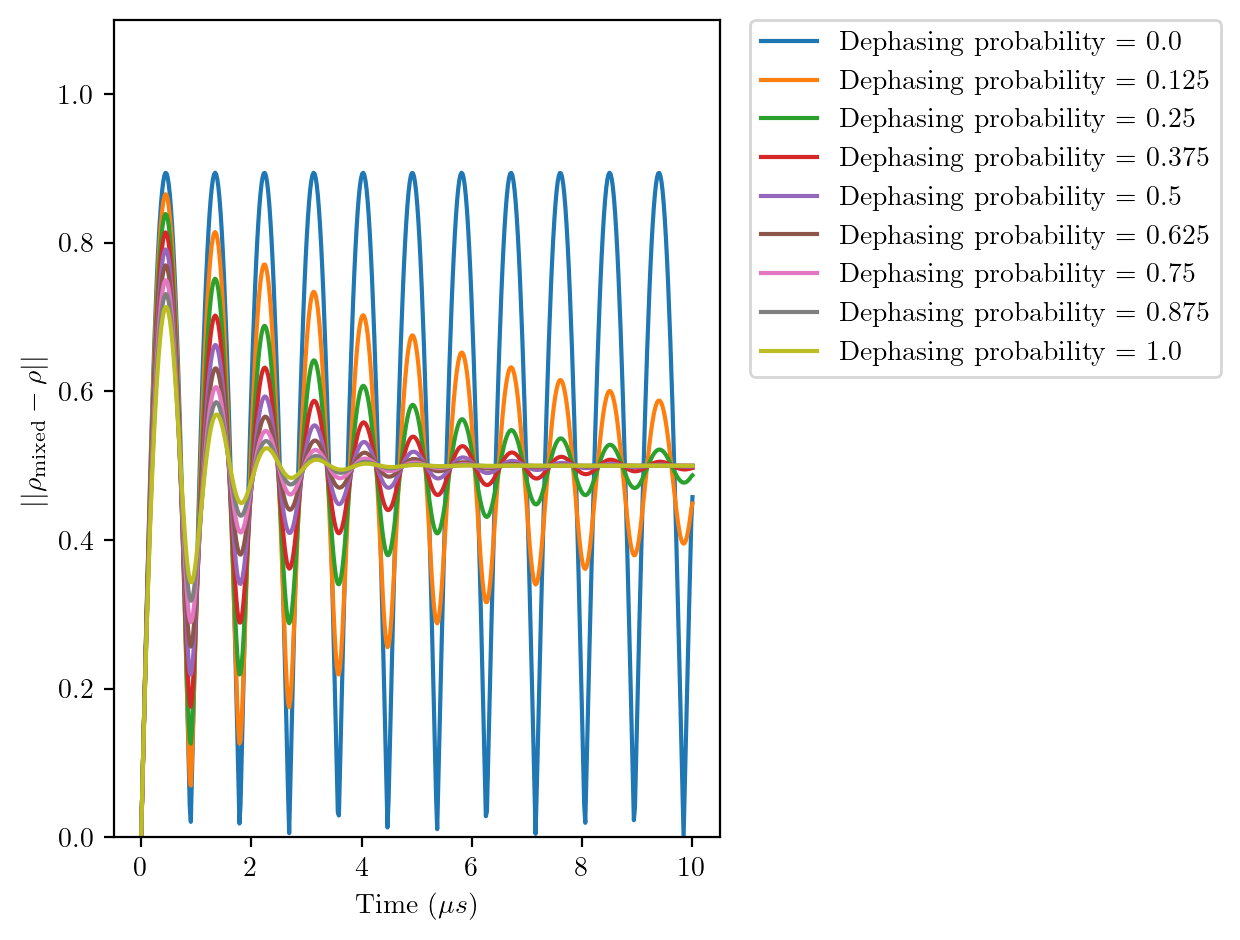

In [12]:
plot_distance(times, gammas, tr_distances)

For $0 < p \leq1$, since $\rho_{mixed}$ is constant, We have a similar behavior as the population evolution. The more $p$ increase, the more the convergence to the mixed state is quick. They system is led to a stationary state different whose distance from $\rho_{mixed}$ is $0.5$.

### Antiferromagnetic state preparation

We would like to analyse the dephasing noise effect in the antiferromagnetic state preparation. We already how the dephasing noise acts on a single qubit, now we are interested on the many body case.

The pulse and the register are defined by the following parameters

In [13]:
# Parameters in rad/µs and ns
Omega_max = 2.3 * 2 * np.pi
U = Omega_max / 2.3

delta_0 = -6 * U
delta_f = 2 * U

t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000

R_interatomic = Chadoq2.rydberg_blockade_radius(U)

Before trying a multi-qubit configuration, let us see how the system behave with a single qubit fired by a more complicated pulse as before.

In [14]:
N_side = 1

reg = Register.square(N_side, R_interatomic, prefix="q")
print(f"Interatomic Radius is: {R_interatomic}µm.")

Interatomic Radius is: 9.756753962298905µm.


We compose our pulse sequence

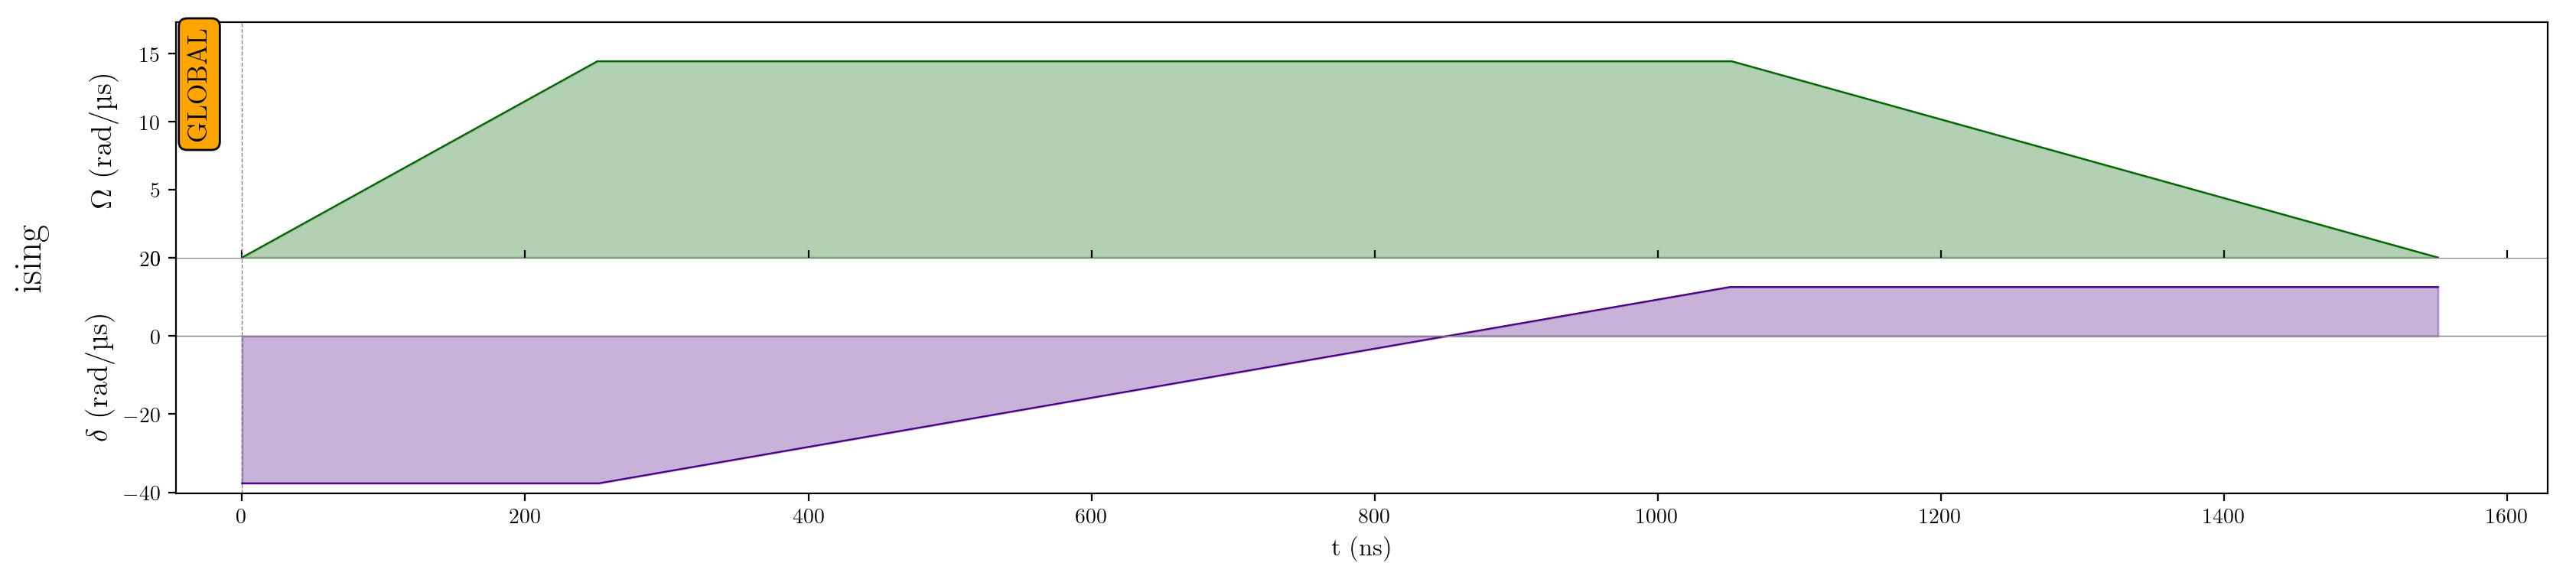

In [15]:
rise = Pulse.ConstantDetuning(
    RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
)
sweep = Pulse.ConstantAmplitude(
    Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.0
)
fall = Pulse.ConstantDetuning(
    RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0
)

seq = Sequence(reg, Chadoq2)
seq.declare_channel("ising", "rydberg_global")

seq.add(rise, "ising")
seq.add(sweep, "ising")
seq.add(fall, "ising")

seq.draw()

#### Simulation

In [17]:
#Clean simulation
clean_simu = Simulation(seq, sampling_rate=0.05)
results = []
noisy_pops = []
tr_distances = []
mixed_states = []
clean_pop = clean_dynamics(clean_simu)
for gamma in gammas:
    print("Dephasing probability = ", gamma/2)
    # Configure the dephasing noise
    config= SimConfig(
        noise="eff_noise",
        eff_noise_opers= [qutip.qeye(2), qutip.sigmaz()],
        eff_noise_probs= [1 - gamma/2, gamma/2]
    )
    simu, result  = noisy_dynamics(clean_simu, config, gamma)

    # Compute the mixed_state expectation value
    rho = result.states[0]
    psi_0 = simu.initial_state
    mixed_state = mixed_state_stats(simu, rho)

    # Ground state population evolution and distance from the mixed state
    noisy_pop = get_population_evolution(result, state=psi_0)
    tr_distance = trace_distance_evolution(rho, result)

    # Storage
    results.append(result)
    noisy_pops.append(noisy_pop)
    tr_distances.append(tr_distance)
    mixed_states.append(mixed_state)

Dephasing probability =  0.0
Dephasing probability =  0.125
Dephasing probability =  0.25
Dephasing probability =  0.375
Dephasing probability =  0.5
Dephasing probability =  0.625
Dephasing probability =  0.75
Dephasing probability =  0.875
Dephasing probability =  1.0


Here the expectation value of the mixed is no more decreasing but increasing and are all different.

/home/varda/.virtualenvs/pulser/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


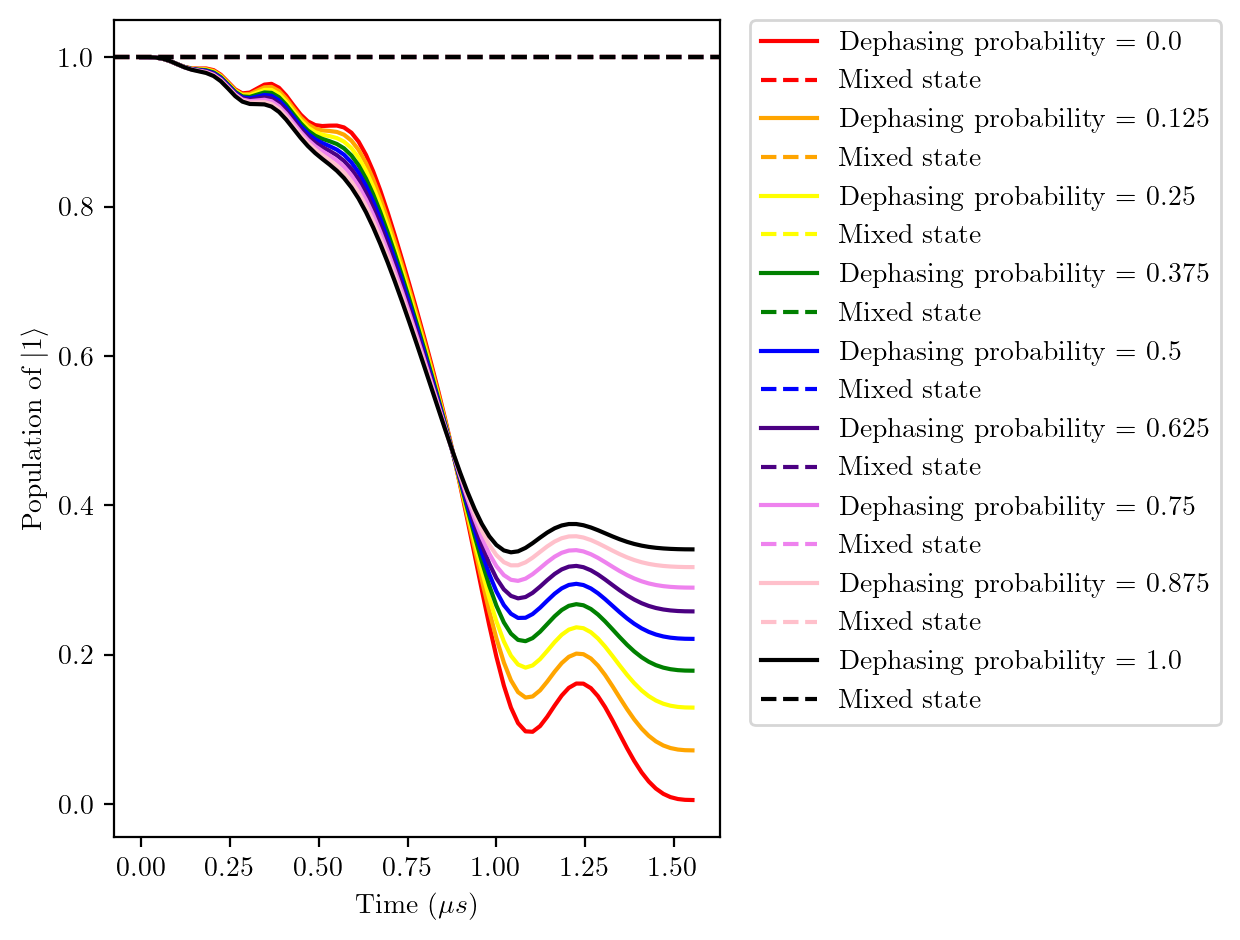

In [18]:
times = results[0]._sim_times
plot_population(times, gammas, noisy_pops, mixed_states)

Each curve converges to a different limit. What is quite surprising is the curves are quite similar: they all decrease to a constant limit. Even when the dephasing effect is absent. The dephasing effect here just brings that limit closer to the curve. The more $p$ increases, the more the stationary state is higher.
The other characteristics of the curves remain the same.

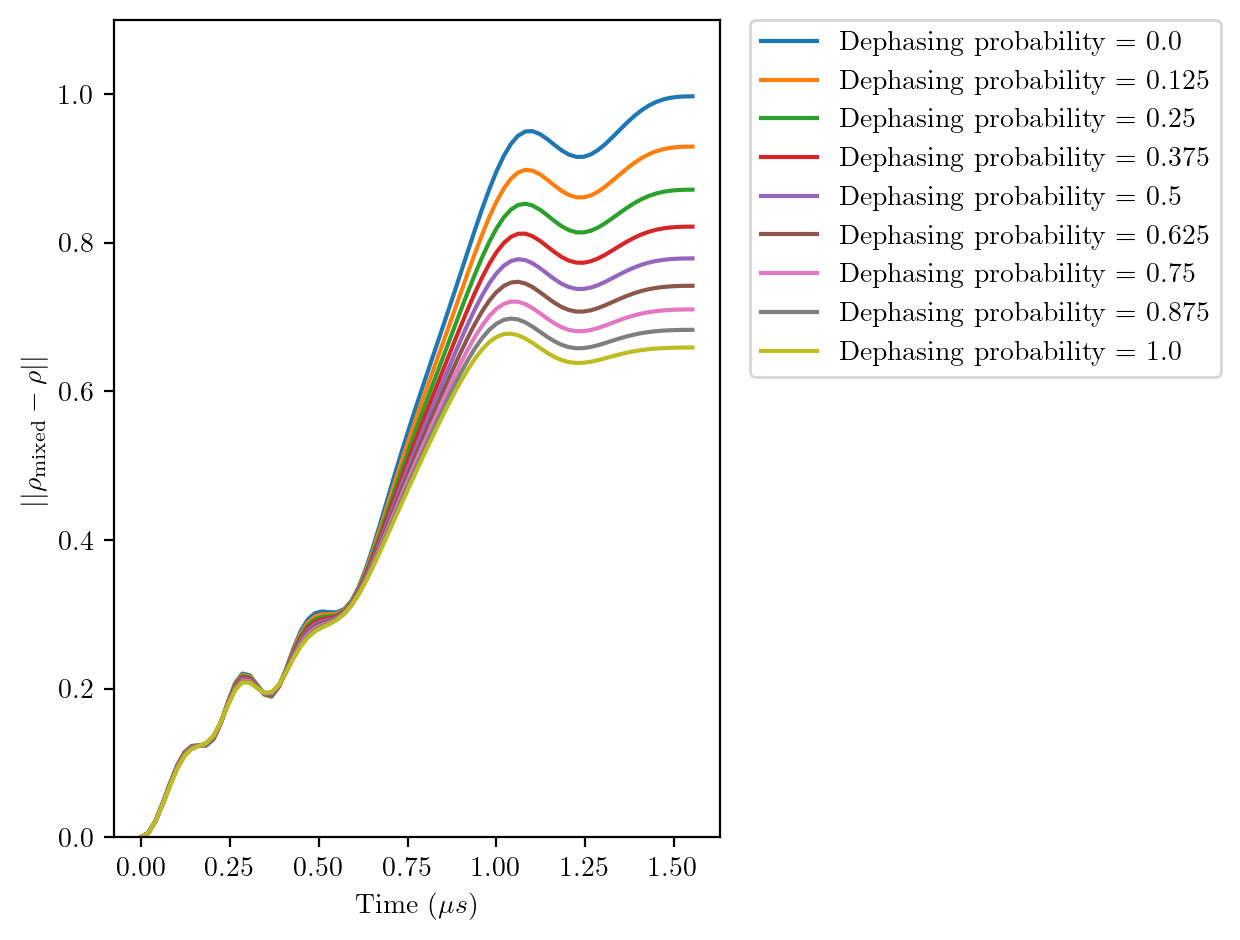

In [19]:
plot_distance(times, gammas, tr_distances)

The dephasing noise reduce the trace distance to the mixed state but it is still quite far from it as we noticed in our first example. 

#### Many body system

Now we get to a more interesting part: the multi qubit case.

Interatomic Radius is: 9.756753962298905µm.


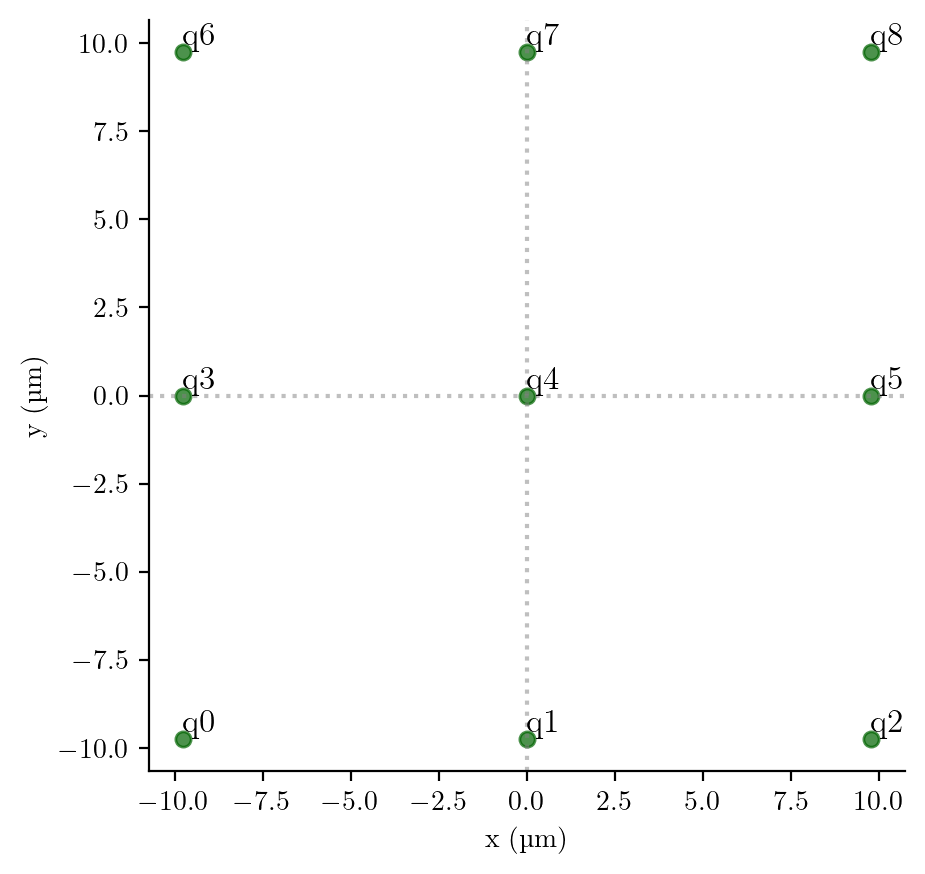

In [20]:
N_side = 3

reg = Register.square(N_side, R_interatomic, prefix="q")
print(f"Interatomic Radius is: {R_interatomic}µm.")
reg.draw()

Now we build the sequence

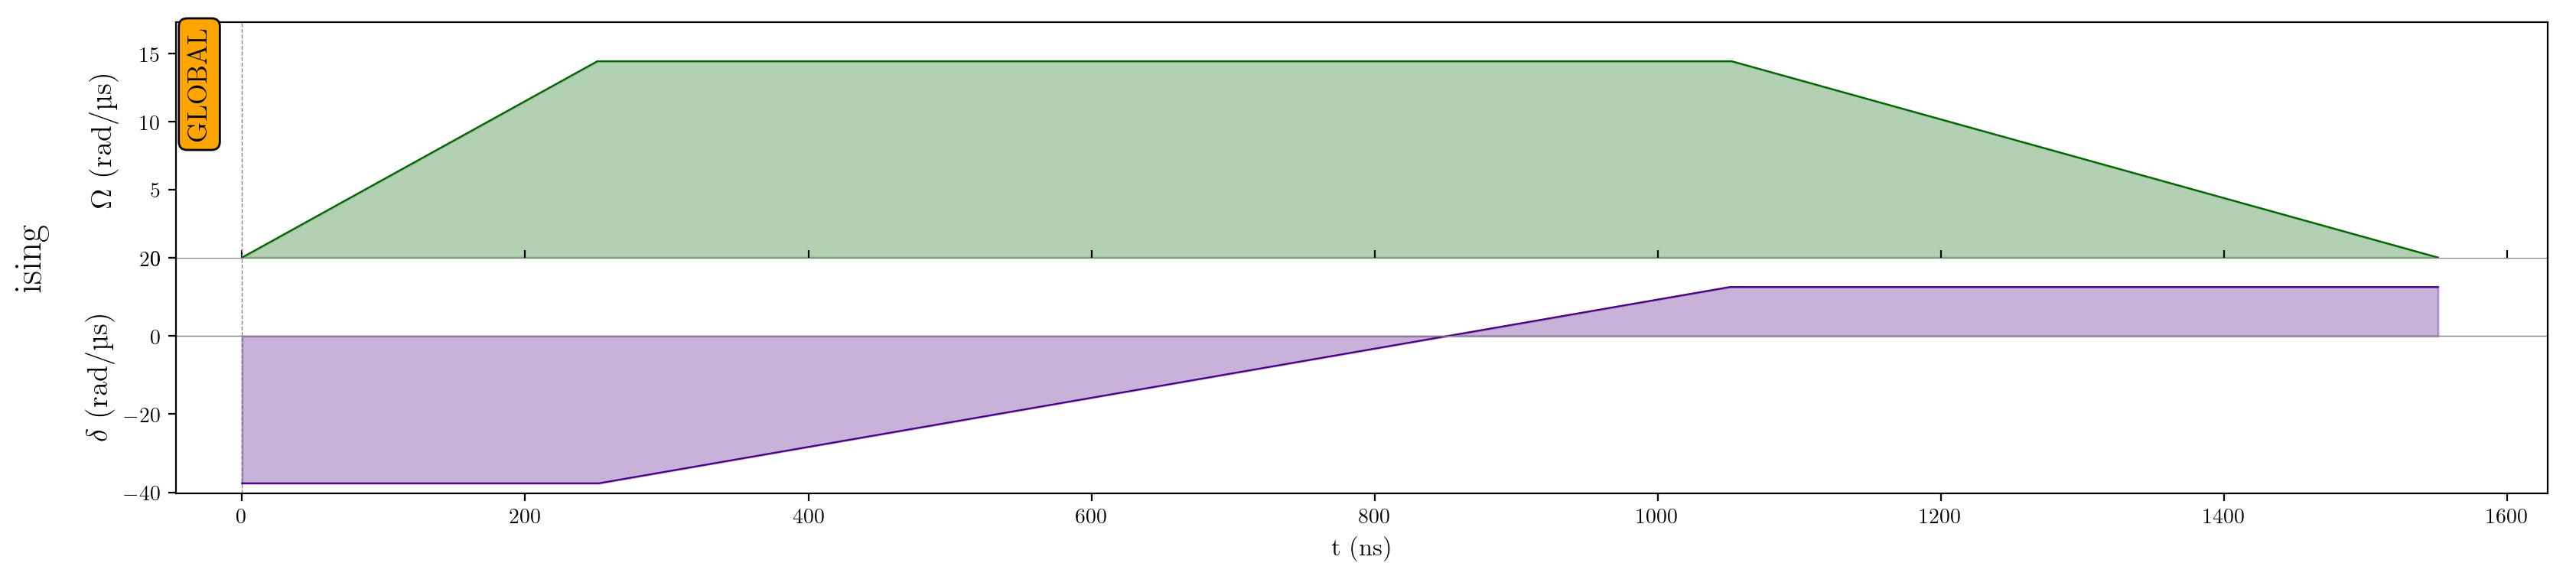

In [21]:
rise = Pulse.ConstantDetuning(
    RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
)
sweep = Pulse.ConstantAmplitude(
    Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.0
)
fall = Pulse.ConstantDetuning(
    RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0
)

seq = Sequence(reg, Chadoq2)
seq.declare_channel("ising", "rydberg_global")

seq.add(rise, "ising")
seq.add(sweep, "ising")
seq.add(fall, "ising")

seq.draw()

Let's see first what happen without any noise

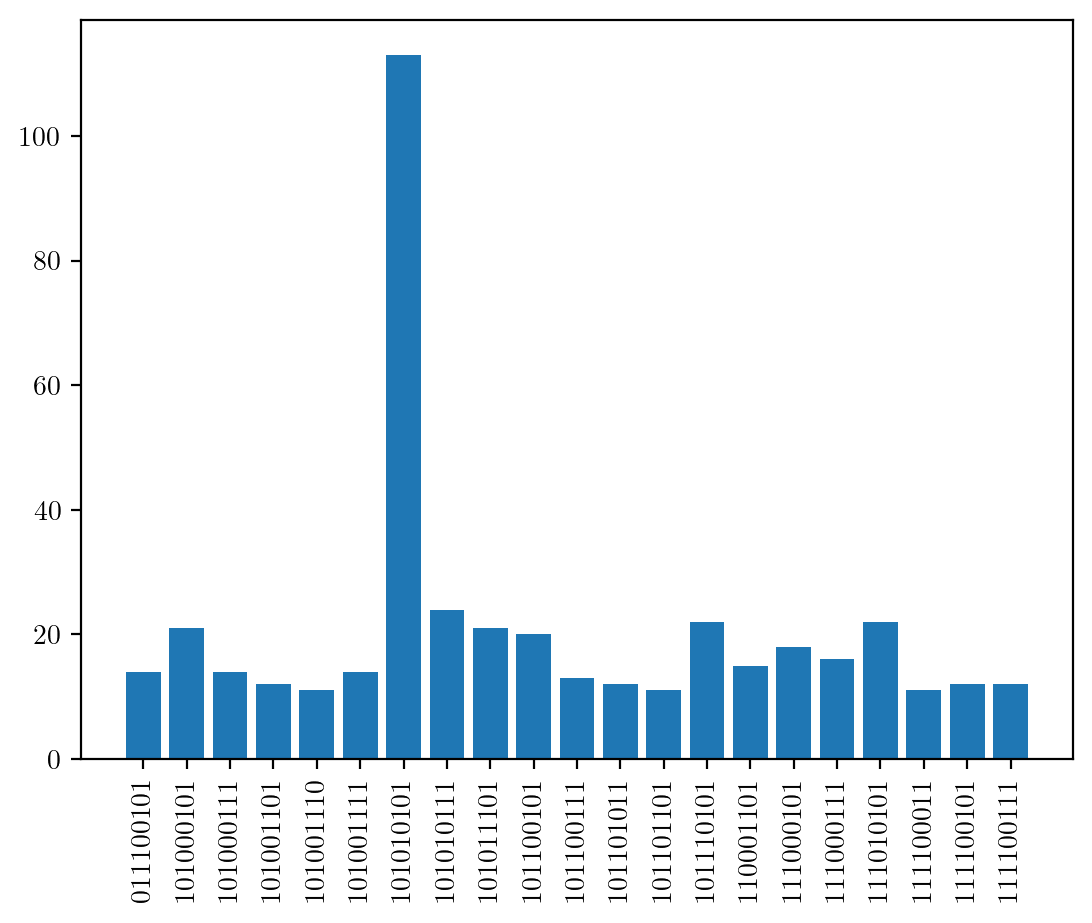

In [22]:
clean_simu = Simulation(seq, sampling_rate=0.05)
clean_results = clean_simu.run()
count = clean_results.sample_final_state()

most_freq = {k: v for k, v in count.items() if v > 10}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.show()

The more likely state is then the antiferromagnetic state as expected. Let's put some noise in the game.

The many body system is quite different. The dephasing channel we implemented is valid if and only if the dephasing probability is low enough. What we called the uncorrelated noise approximation.

Basically, to be able to write easily the collapse operator of the dephasing channel for a many body system, we assume that one bit a the time is modified. And to make it happen, the dephasing probability $p$ needs to be low so that $p^n\simeq0$, where n is the number of qubits.

For now we didn't prevent the user to simulate the dephasing channel where p is "large"($p>0.1$). But we put a warning to alert the user that the domain in which he is working is out the approximation used which can make the results difficult to interpret.

In [23]:
gammas = np.linspace(0,0.195,3)
results = []
noisy_pops = []
tr_distances = []
mixed_states = []

In [24]:
results = []
noisy_pops = []
tr_distances = []
mixed_states = []
clean_pop = clean_dynamics(clean_simu)
for gamma in gammas:
    print("Dephasing probability = ", gamma/2)
    # Configure the dephasing noise
    config= SimConfig(
        noise="eff_noise",
        eff_noise_opers= [qutip.qeye(2), qutip.sigmaz()],
        eff_noise_probs= [1 - gamma/2, gamma/2]
    )
    simu, result  = noisy_dynamics(clean_simu, config, gamma)

    # Compute the mixed_state expectation value
    rho = result.states[0]
    psi_0 = simu.initial_state
    mixed_state = mixed_state_stats(simu, rho)

    # Ground state population evolution and distance from the mixed state
    noisy_pop = get_population_evolution(result, state=psi_0)
    tr_distance = trace_distance_evolution(rho, result)

    # Storage
    results.append(result)
    noisy_pops.append(noisy_pop)
    tr_distances.append(tr_distance)
    mixed_states.append(mixed_state)

Dephasing probability =  0.0
Dephasing probability =  0.04875
Dephasing probability =  0.0975


/home/varda/.virtualenvs/pulser/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


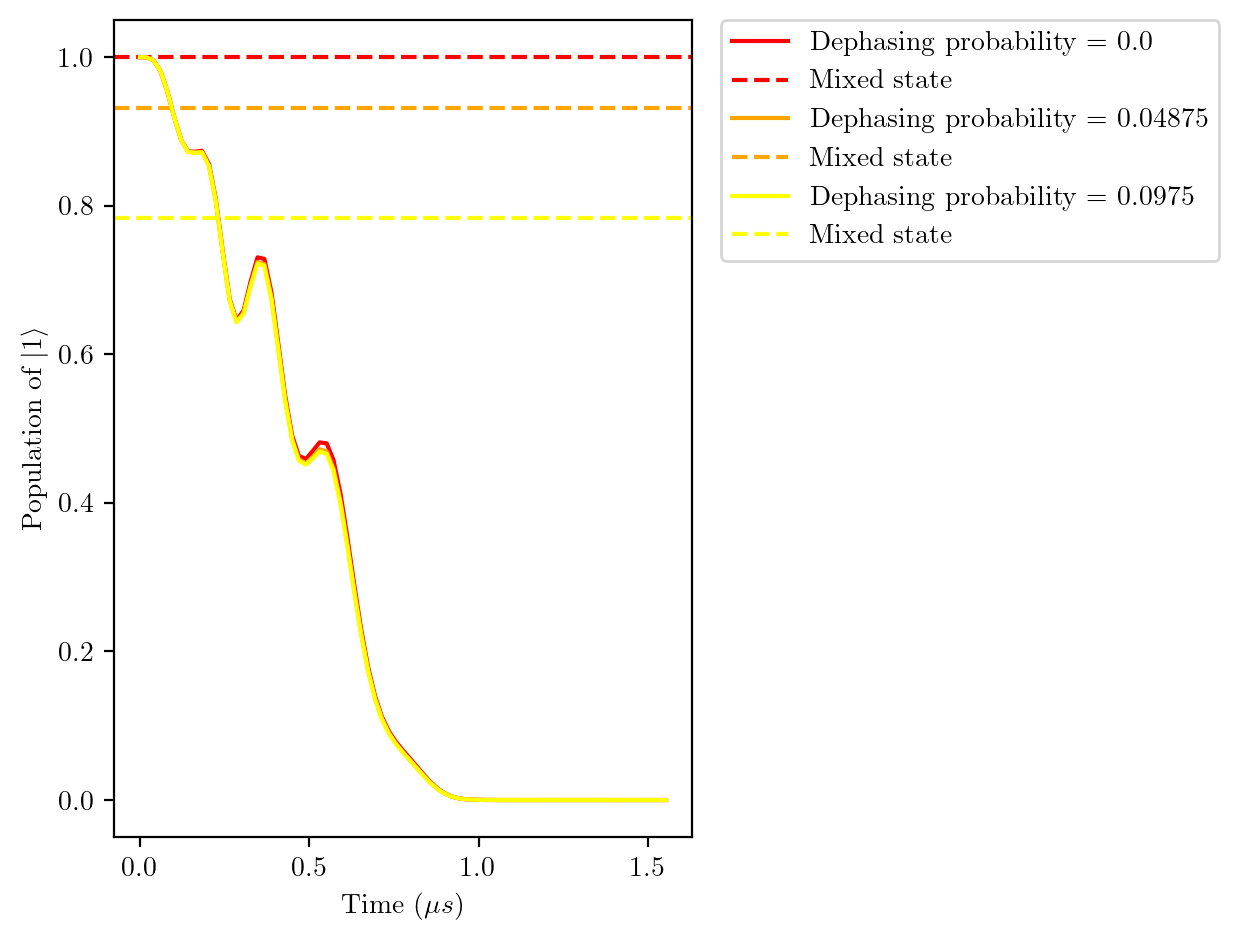

In [25]:
times = results[0]._sim_times
plot_population(times, gammas, noisy_pops, mixed_states)

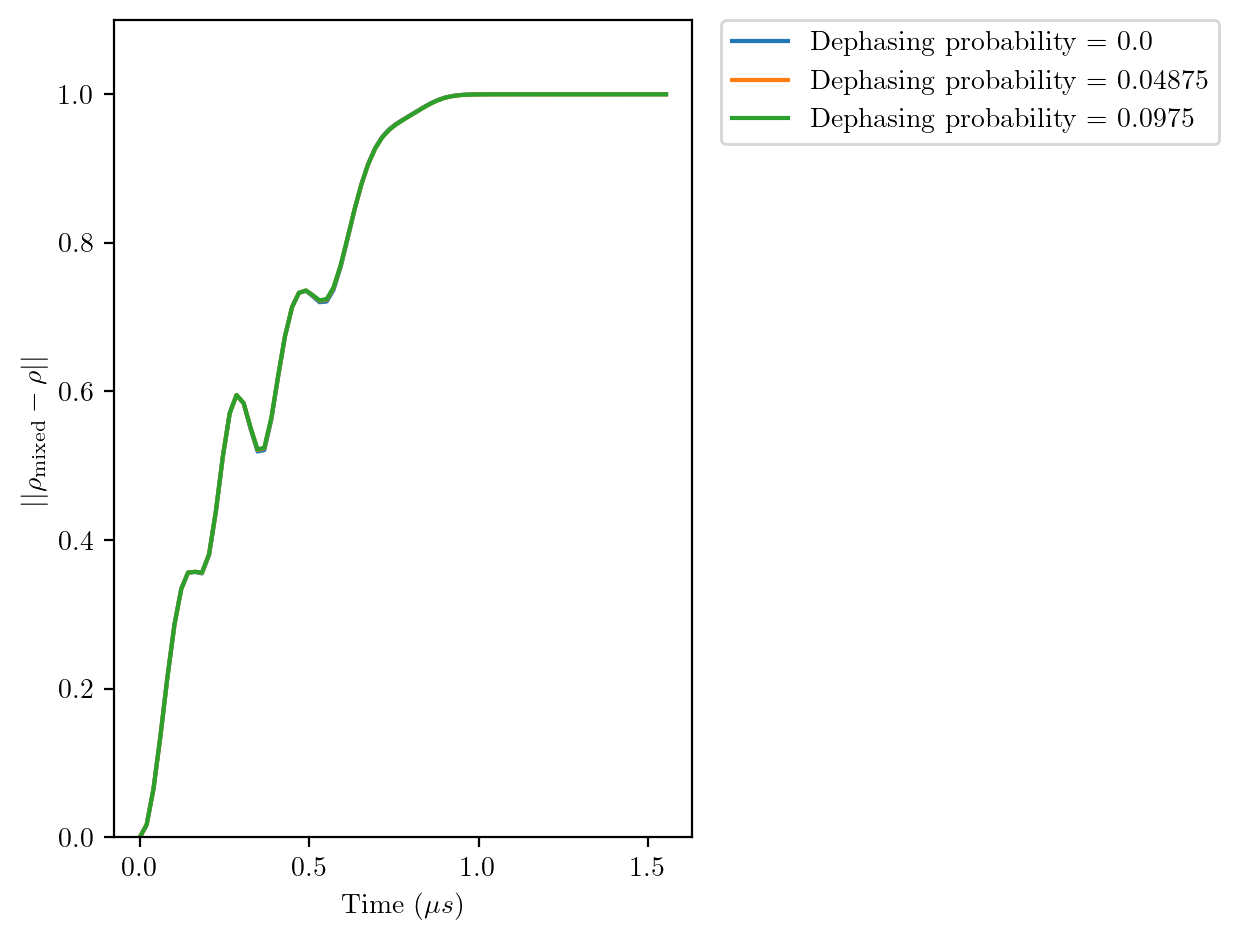

In [26]:
plot_distance(times, gammas,tr_distances)

The single qubit case and the multi qubit case are similar. This is because the is no noise correlation among qubit due to the approximation we choose. Let's try to sample the final state.

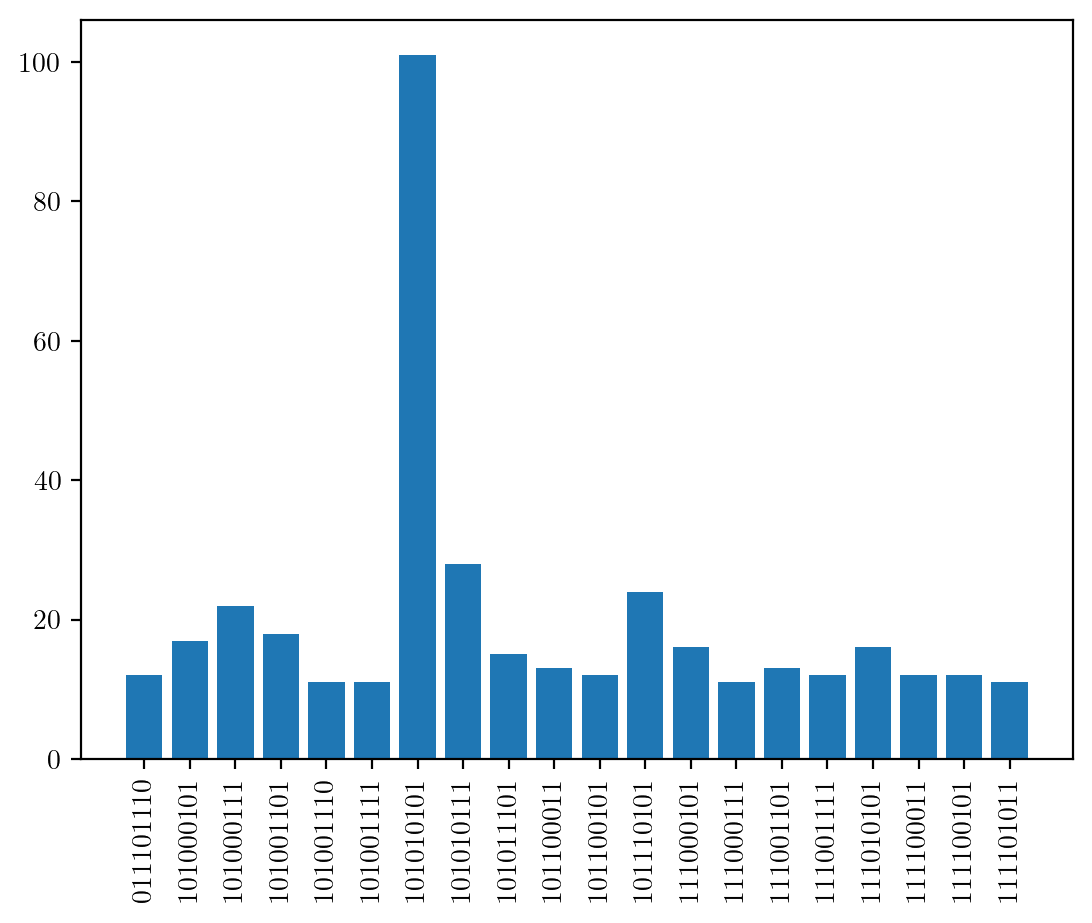

In [27]:
count = results[-1].sample_final_state()

most_freq = {k: v for k, v in count.items() if v > 10}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.show()